<div class="alert alert-info">
<h2> Ссылка на презентацию </h2>
    
https://drive.google.com/file/d/1Y3w0JF4vOKSBhalMYtN08C0n-6wSIzja/view?usp=sharing
    
</div>

# Банки — Анализ оттока клиентов

### Задача**:**

Проанализировать клиентов регионального банка и выделить портрет клиентов, которые склонны уходить из банка.

### Описание датасетов

Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

Колонки:

- `userid` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `City` — город,
- `Gender` — пол,
- `Age` — возраст,
- `Objects` — количество объектов в собственности,
- `Balance` — баланс на счёте,
- `Products` — количество продуктов, которыми пользуется клиент,
- `CreditCard` — есть ли кредитная карта,
- `Loyalty` — активный клиент,
- `estimated_salary` — заработная плата клиента,
- `Churn` — ушёл или нет.

## 1. Загрузка данных. 

In [1]:
#Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import math as mth
from scipy import stats as st
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans

In [2]:
#Считаем датасет 
path = '/datasets/'
df = pd.read_csv(path + 'bank_dataset.csv')
# Посмотрим данные
df.head(10)

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0
5,15616748,645,Рыбинск,М,44,8,113755.78,2,1,0,149756.71,1
6,15635267,822,Ярославль,М,50,7,NaN,2,1,1,10062.80,0
7,15698884,376,Ростов Великий,Ж,29,4,115046.74,4,1,0,119346.88,1
8,15835101,501,Ярославль,М,44,4,142051.07,2,0,1,74940.50,0
9,15635125,684,Ярославль,М,27,2,134603.88,1,1,1,71725.73,0


In [3]:
# Посмотрим информацию о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
userid              10000 non-null int64
score               10000 non-null int64
City                10000 non-null object
Gender              10000 non-null object
Age                 10000 non-null int64
Objects             10000 non-null int64
Balance             6383 non-null float64
Products            10000 non-null int64
CreditCard          10000 non-null int64
Loyalty             10000 non-null int64
estimated_salary    10000 non-null float64
Churn               10000 non-null int64
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


В датасете 12 колонок и 10 тысяч строк. Пропуски отсутсвуют во всех столбцах кроме "Баланса". Категориальные данные, такие как активность клиента и наличие кредитной карты уже преобразованы в систему 1/0. Пол клиента принимает значения М и Ж. 

## 2. Предварительная обработка данных

### 2.1.Проверка типов данных 

In [4]:
# Проверим типы данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
userid              10000 non-null int64
score               10000 non-null int64
City                10000 non-null object
Gender              10000 non-null object
Age                 10000 non-null int64
Objects             10000 non-null int64
Balance             6383 non-null float64
Products            10000 non-null int64
CreditCard          10000 non-null int64
Loyalty             10000 non-null int64
estimated_salary    10000 non-null float64
Churn               10000 non-null int64
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [5]:
# Проверим наличие дубликатов
df.duplicated().sum()

0

Все типы данных имеют приемлемые для анализа значение. Дубликатов не обнаружено.

### 2.2.Проверка данных на пропуски

In [6]:
df['Balance'].describe()

count      6383.000000
mean     119827.493793
std       30095.056462
min        3768.690000
25%      100181.975000
50%      119839.690000
75%      139512.290000
max      250898.090000
Name: Balance, dtype: float64

Пропуски присутствуют только в балансе на карте, их около 36%. При первом взгляде на данные таблицы, пропуски в балансе не зависит от других данных.Минимальное значение баланса равно 3.7к, поэтому можно предположить, чтопропуски-это нулевые значение. Но обычно на карте остаются небольшие суммы (копейки), даже если клиент ею не пользуется, и они должны значиться в балансе. Пропуски в данных не помешают дальнейшему анализу, поэтому оставляем их. При изучении зависимости оттока клиента от баланса на карте можно будет очистить датасет от пропусков.

## 3. Исследовательский анализ данных (EDA)

### 3.1.Исследование структуры датасета

In [7]:
# Изучим средние значения и отклонения признаков
df.describe()

,userid,score,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,6383.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.573368e+07,650.528800,38.921800,5.012800,119827.493793,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,30095.056462,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.560844e+07,350.000000,18.000000,0.000000,3768.690000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.567126e+07,584.000000,32.000000,3.000000,100181.975000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.573347e+07,652.000000,37.000000,5.000000,119839.690000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.579597e+07,718.000000,44.000000,7.000000,139512.290000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.585843e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Баллы кредитного скоринга принимают значение от 350 до 850, в среднем 650 на клиента с разбросом около 100 баллов. Возраст клиентов варьируется от 18 до 92 лет, у среднестатистическому клиенту 39 лет. В среднем в собственности клиентов 5 объектов. Баланс на карте варьируется от 4к до 251к рублей, среднее значение 120к рублей. Все клиенты используют от 1 до 4 продуктов банка, чаще всего 1-2-мя продуктами. Кредитная карта есть у 70% клиентов. Активных в плане банковской истории около 50% клиентов в выборке. Зредняя зп клиента 100к. 20% клиентов в выборке перестали пользоваться услугами банка.

### 3.2.Исследование распределения признаков

In [8]:
# Изучим распределение клиентов по полу
df['Gender'].value_counts()

М    5457
Ж    4543
Name: Gender, dtype: int64

In [9]:
# Изучим распределение клиентов по городам
df['City'].value_counts()

Ярославль         5014
Ростов Великий    2509
Рыбинск           2477
Name: City, dtype: int64

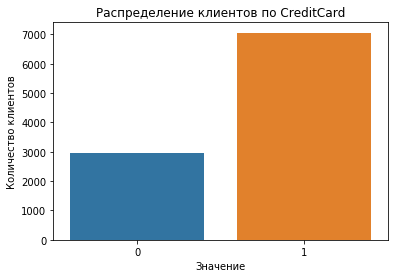

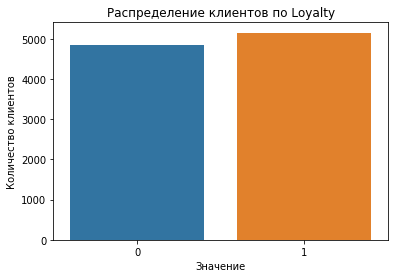

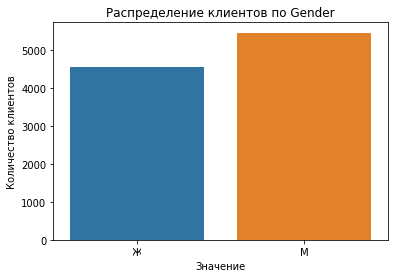

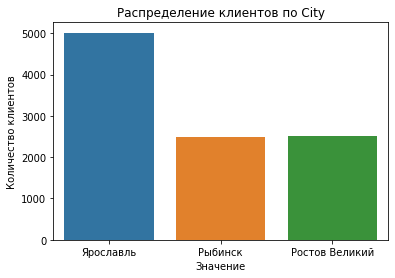

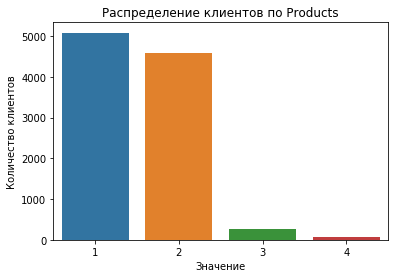

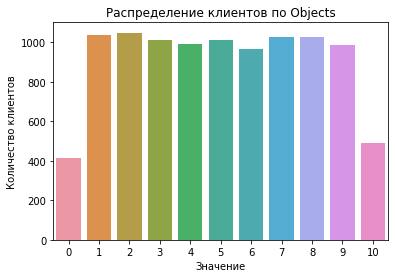

In [10]:
# Дискретные признаки визуализируем методом "countplot"
for col in df[['CreditCard', 'Loyalty', 'Gender', 'City', 'Products', 'Objects']].columns:
    ax = sns.countplot(x = col, data = df)
    plt.title('Распределение клиентов по ' + col)
    plt.ylabel('Количество клиентов')
    plt.xlabel('Значение')
#    plt.legend(['Есть карта', 'Нет карты'])
    plt.show()

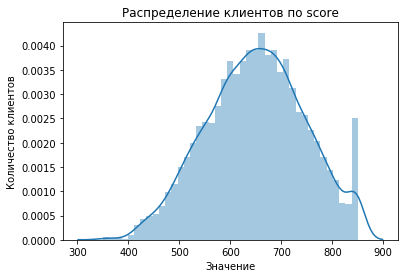

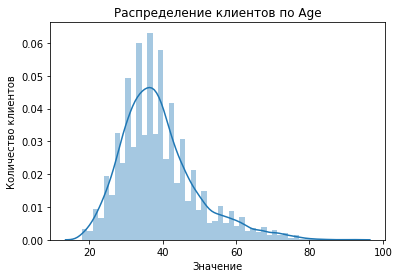

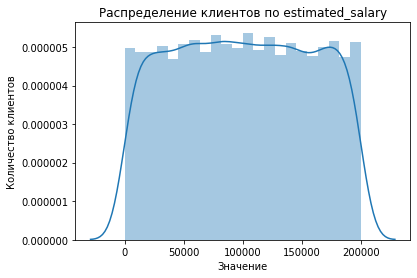

In [11]:
# Непрерывные признаки визуализируем методом "distplot"
for col in df[['score', 'Age', 'estimated_salary']].columns:
    sns.distplot(df[col])
    plt.title('Распределение клиентов по ' + col)
    plt.ylabel('Количество клиентов')
    plt.xlabel('Значение')
#    plt.legend(['Ок', 'Отток'])
    plt.show()

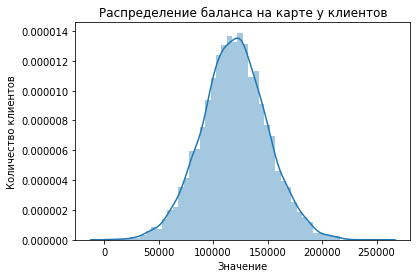

In [12]:
# Посмотрим на распределение баланса клиентов
df_balance = df.dropna()

sns.distplot(df_balance['Balance'])
plt.title('Распределение баланса на карте у клиентов')
plt.ylabel('Количество клиентов')
plt.xlabel('Значение')
#plt.legend(['Ок', 'Отток'])
plt.show()

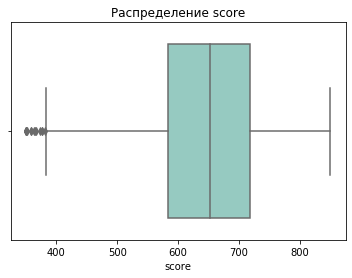

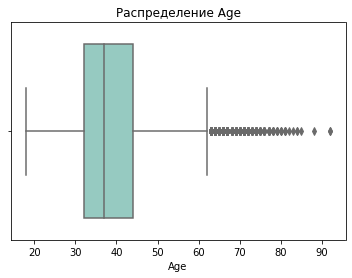

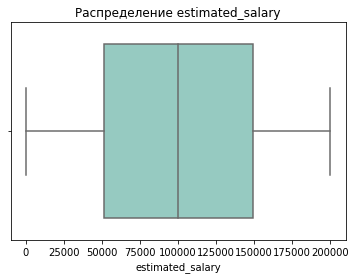

In [13]:
# Посмотрим на boxplot для различных признаков
for col in df[['score', 'Age','estimated_salary']]:
    ax = sns.boxplot(x=df[col], palette="Set3")
    plt.title('Распределение ' + col)
    plt.show()

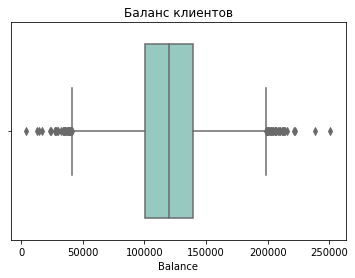

In [14]:
# Посмотрим на boxplot для различных признаков
ax = sns.boxplot(x=df_balance['Balance'], palette="Set3")
plt.title('Баланс клиентов')
plt.show()

В выборке примерно равное количество мужчин и женщин. Половина клиента пользуется услугами банка в Ярославле, остальные пополам распределены по двум другим городам. Очень малый процент клиентов пользуется 3-4-мя продуктами банка. У редких клиентов совсем нет имущества или же 10 объектов, остальные значения распределены равномерно. Распределение баллов скоринга походит на нормальное распределение со сдвигом вправо, но на уровне 850 баллов  имеется выброс.Распределение возраста клиентов имеет длинный хвост в большую сторону, в основном возраст клиентов 30-50 лет. Зарплата клиентов распределена почти равномерно, скорее всего сотрудники банка вносят примерное ее значение. Баланс клиентов на счету имеет вид нормального распределения с довольно длтинными хвостами в обе стороны. 

### 3.3.Корреляционный анализ

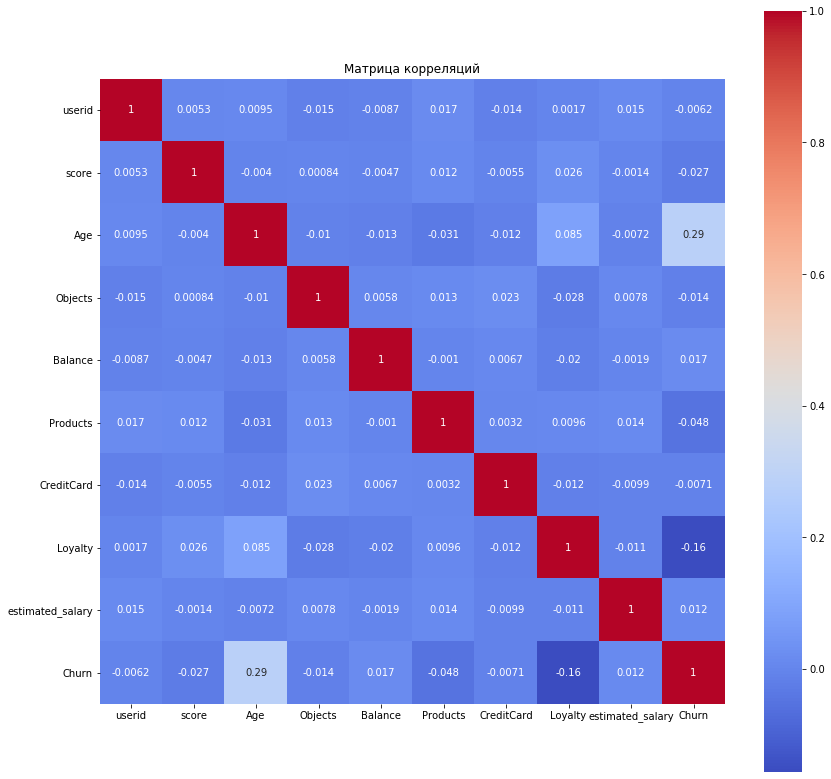

In [15]:
#построим и отрисуем матрицу корреляций
cm = df.corr() #вычисляем матрицу корреляций
fig, ax = plt.subplots(figsize = (14, 14))

#нарисуем тепловую карту с подписями для матрицы корреляций
sns.heatmap(cm, annot = True, square=True, cmap="coolwarm")
#ваш код здесь
plt.title('Матрица корреляций')
plt.show()

Согласно шкале Чеддока, связь между всеми признаками очень слабая. Больше всего между собой коррелируют возраст и отток. Чем старше клиент, тем больше вероятность, что он перестанет быть клиентом банка.Но и эта связь находится между уровнями "очень слабая" и "слабая".

## 4. Решений основной задачи - анализ оттока клиентов

### 4.1.Исследовать долю оттока для каждого из признаков

In [16]:
# Сгруппируем данные по стобцу оттока
df.groupby('Churn').mean()

,userid,score,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary
Churn,,,,,,,,,
0,1.573390e+07,651.853196,37.408389,5.033279,119535.864270,1.544267,0.707146,0.554565,99738.391772
1,1.573279e+07,645.351497,44.837997,4.932744,120746.971132,1.475209,0.699067,0.360825,101465.677531


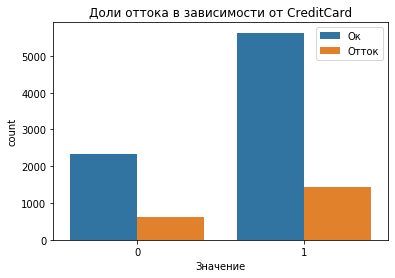

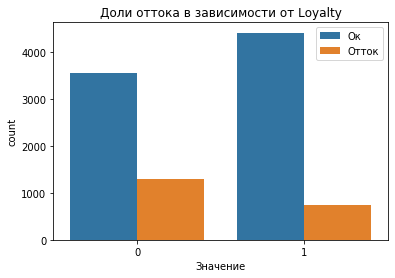

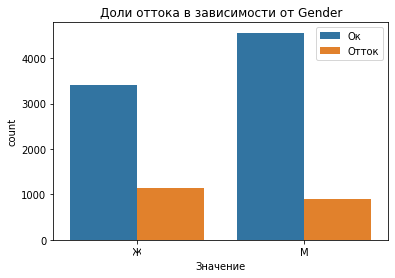

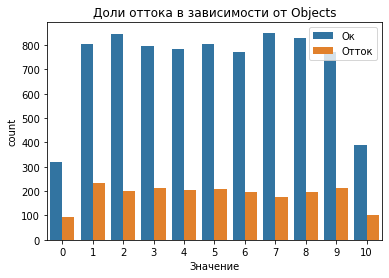

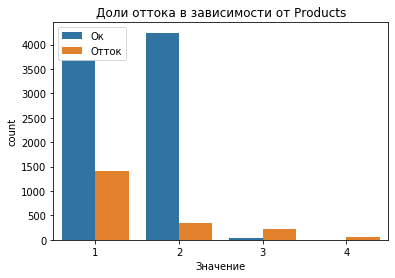

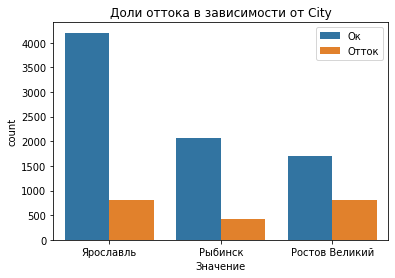

In [17]:
#Бинарные и дискретные признаки визуализируем методом "countplot"
for col in df[['CreditCard', 'Loyalty', 'Gender','Objects', 'Products', 'City']].columns:
    ax = sns.countplot(x = col, hue = 'Churn', data = df)
    plt.title('Доли оттока в зависимости от ' + col)
#    plt.ylabel('Количество клиентов')
    plt.xlabel('Значение')
    plt.legend(['Ок', 'Отток'])
    plt.show()

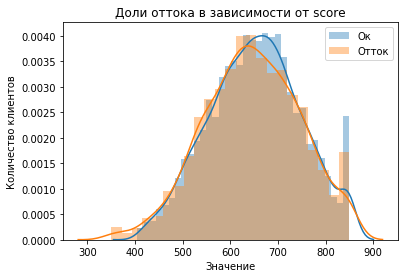

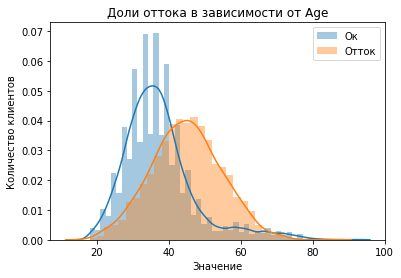

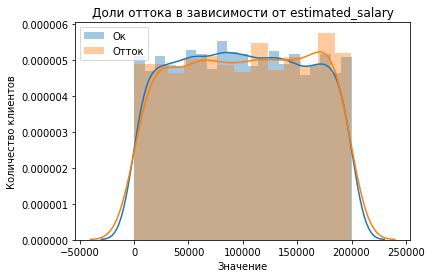

In [18]:
# Непрерывные признаки визуализируем методом "distplot"
for col in df[['score', 'Age', 'estimated_salary']].columns:
    sns.distplot(df.query('Churn == 0')[col])
    sns.distplot(df.query('Churn == 1')[col])
    plt.title('Доли оттока в зависимости от ' + col)
    plt.ylabel('Количество клиентов')
    plt.xlabel('Значение')
    plt.legend(['Ок', 'Отток'])
    plt.show()

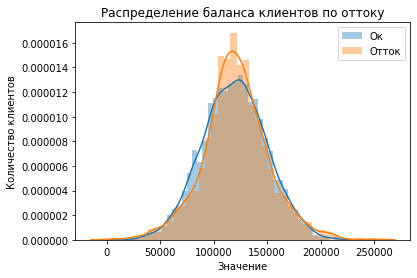

In [19]:
df_balance = df.dropna()

sns.distplot(df_balance.query('Churn == 0')['Balance'])
sns.distplot(df_balance.query('Churn == 1')['Balance'])
plt.title('Распределение баланса клиентов по оттоку')
plt.ylabel('Количество клиентов')
plt.xlabel('Значение')
plt.legend(['Ок', 'Отток'])
plt.show()

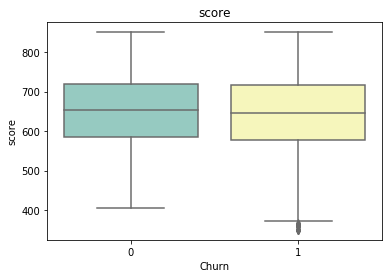

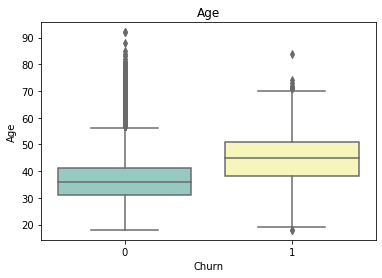

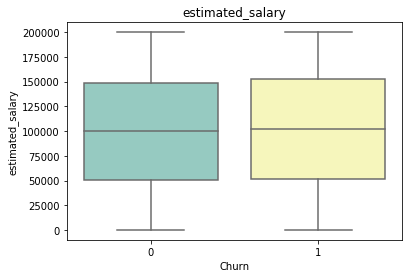

In [20]:
# Посмотрим на boxplot для различных признаков
for col in df[['score', 'Age','estimated_salary']].columns:
    ax = sns.boxplot(x="Churn", y= col,
                 data=df, palette="Set3")
    plt.title(col)
    plt.show()

Средний скоринговый баланс примерно равен для ушедших и оставшихся клиентов, а вот клиенты с минимальными значениями баланса больше склонны уходить, так как у распределений отточников больший хвост в начале. Клиенты 40-45+ более склонны уходить, и такая тенденция наблюдается примерно до 65 лет. Количество объектов в собственности, судя по всему, не влияет на отток. На средних значениях баланса клиентов отток повышается. Отток для клиентов, использующих 3-4 продукта банка, выше, чем для 1-2 продуктов. Наличие кредитной карты слабо влияет на отток. Для активных/лояльных клиентов отток заметно ниже. Зарплата не значительно влияет нра отток, но на значении примерно 180к имеется локальный пик распределения ущедших клиентов. Клиенты-мужчины заметно реже уходят из банка, нежели женщины. В процентном соотношении ниже всего отток клиентов в Ярославле, а выше всего в Ростове Великом.

### 4.2.Выделить портреты клиентов, которые склонны уходить из банка

Для выделения портрета клиентов будем использовать кластеризацию на основании алгоритма K-Means

In [21]:
# Напишем функции, которые будут присваивать числовые значения категориальным клиентам
df_full = df.dropna()
# Введем функцию, которая классифицирует этаж квартиры
def gender_category(row):
    if row[3] == 'Ж':
        return 1
    else:
        return 0
def city_category(row):
    if row[2] == 'Ярославль':
        return 0
    if row[2] == 'Рыбинск':
        return 1
    else:
        return 2
#Применем ее к нашему датасету с созданием нового столбца
df_full['gender_norm'] = df_full.apply(gender_category, axis = 1)
df_full['city_norm'] = df_full.apply(city_category, axis = 1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [22]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y).
# Удалим удалим столбцы, которые не будут участвовать в кластеризации
X = df_full.drop(['Churn', 'Gender', 'City'], axis = 1)
y = df_full['Churn']

# разделим модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Стандартизируем данные методом StandartScaler
sc = StandardScaler()
X_sc = sc.fit_transform(X)

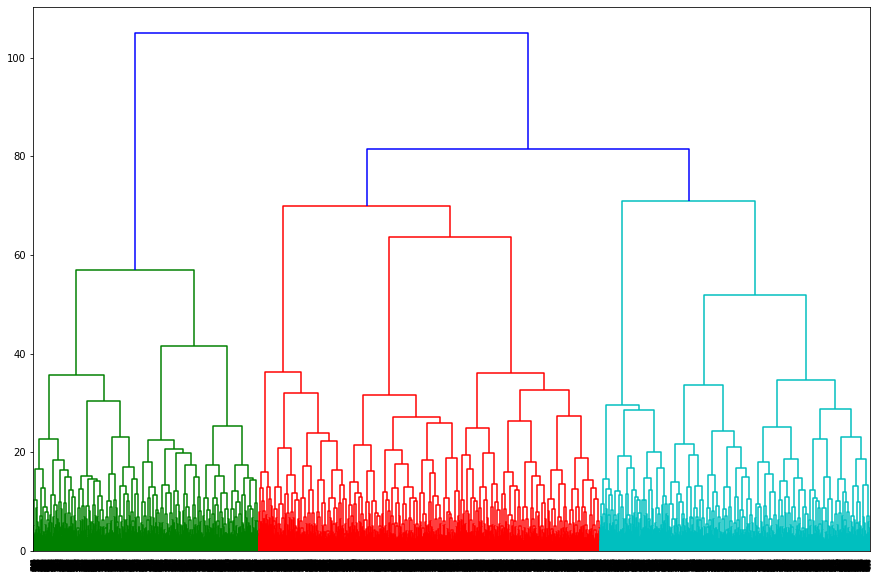

In [23]:
# Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуйте дендрограмму.
plt.figure(figsize=(15, 10))  
linked = linkage(X_sc, method = 'ward') 
dendrogram(linked, orientation='top')
plt.show() 

In [24]:
# Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов
# задаём модель k_means с числом кластеров 3
km = KMeans(n_clusters = 3, random_state = 0)
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 2)
labels = km.fit_predict(X_sc)

# сохраняем метки кластера в поле нашего датасета
df_full['cluster_churn'] = labels

# выводим статистику по средним значениям наших признаков по кластеру
df_full.groupby(['cluster_churn']).mean()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,userid,score,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn,gender_norm,city_norm
cluster_churn,,,,,,,,,,,,
0,1.573541e+07,653.364063,39.524479,4.864583,119519.124656,1.383333,0.0,0.527604,101101.214437,0.242188,0.458333,0.960938
1,1.573200e+07,650.486312,39.381284,4.952713,119179.131747,1.407168,1.0,0.486312,101256.300025,0.296167,1.000000,1.026381
2,1.573221e+07,649.931133,38.791769,5.091687,120599.550880,1.370823,1.0,0.524857,99975.804992,0.194377,0.000000,0.973513


In [25]:
# Посмотрим на число значений в каждом кластере
df_full['cluster_churn'].value_counts()

2    2454
1    2009
0    1920
Name: cluster_churn, dtype: int64

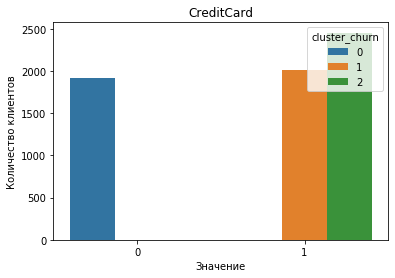

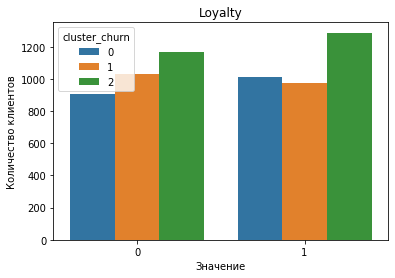

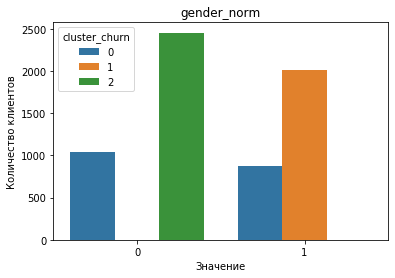

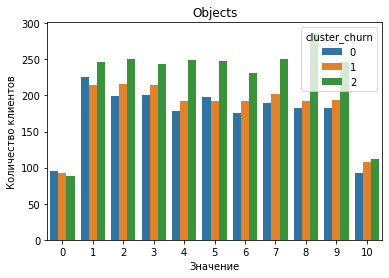

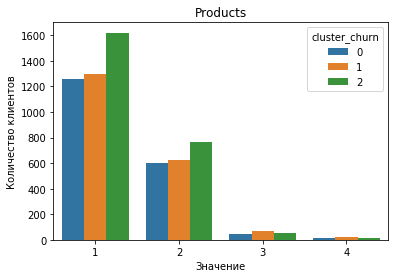

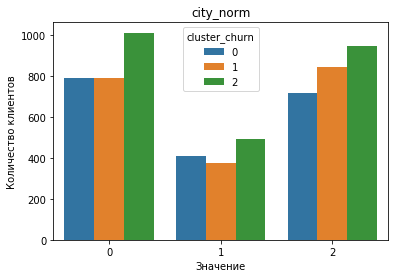

In [26]:
# Дискретные признаки визуализируем методом "countplot"
for col in df_full[['CreditCard', 'Loyalty', 'gender_norm','Objects', 'Products' , 'city_norm']].columns:
    ax = sns.countplot(x = col, hue = 'cluster_churn', data = df_full)
    plt.title(col)
    plt.ylabel('Количество клиентов')
    plt.xlabel('Значение')
#    plt.legend(['Ок', 'Отток'])
    plt.show()

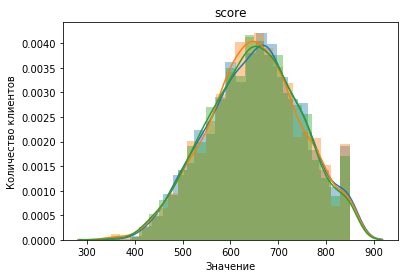

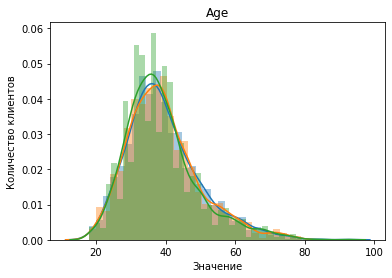

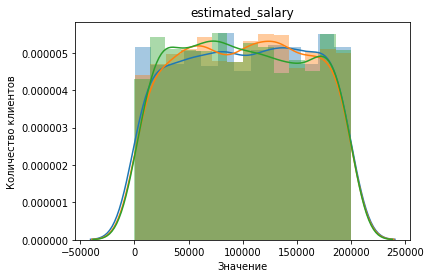

In [27]:
# Непрерывные признаки визуализируем методом "distplot"
for col in df_full[['score', 'Age', 'estimated_salary']].columns:
    sns.distplot(df_full.query('cluster_churn == 0')[col])
    sns.distplot(df_full.query('cluster_churn == 1')[col])
    sns.distplot(df_full.query('cluster_churn == 2')[col])
    plt.title(col)
    plt.ylabel('Количество клиентов')
    plt.xlabel('Значение')
#    plt.legend(['Ок', 'Отток'])
    plt.show()

In [28]:
# Для каждого полученного кластера посчитаем долю оттока
df_mean = df_full.groupby(['cluster_churn']).mean().reset_index()
df_mean['Churn']

0    0.242188
1    0.296167
2    0.194377
Name: Churn, dtype: float64

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

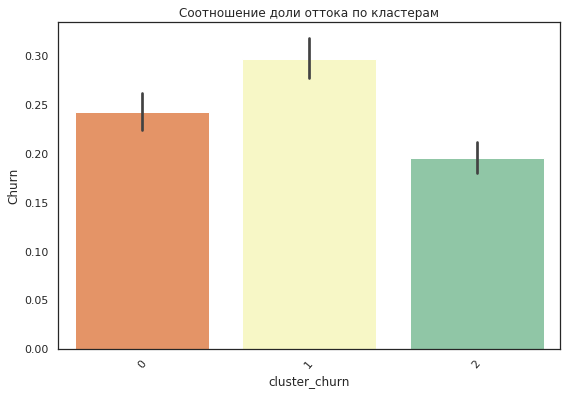

In [29]:
# Дополнительно визуализируем таблицу в виде столбчатых диаграмм
sns.set(style='white')
plt.figure(figsize=(9, 6))
plt.title('Соотношение доли оттока по кластерам')

sns.barplot(x='cluster_churn',y='Churn', data=df_full, palette='Spectral')
plt.xticks(rotation=50) 

На основе построения дендрограммы было выбрано 3 кластера. В каждом клстере от 1920 до 2454. Отток во втором кластере существенно выше, чем в третьем, 30% против 20%. По обученной модели можно сделать вывод, что к отттоку больше склонны клиенты-женщины, по другим признакам выводы сделать сложно.

## 5. Проверка гипотез 
### 5.1.Сформулировать и проверить гипотезу различия дохода между теми клиентами, которые ушли и теми, которые остались

In [30]:
# Разделим выборку на две части по оттоку
df_churn0 = df.query('Churn == 0')
df_churn1 = df.query('Churn == 1')

Обычно, когда имеются две выборки, которые мы хотим сравнить относительно среднего значения некоторой изучаемой переменной, мы используем t-критерий для независимых выборок.
Математических допущения, на которых основан критерий Стьюдента:
- Сравниваемые выборки должны происходить из нормально распределенных совокупностей;
- Дисперсии сравниваемых генеральных совокупностей должны быть равны.

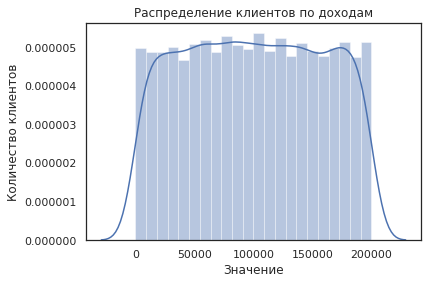

In [31]:
# Еше раз посмотрим на распределение величины доходов
sns.distplot(df['estimated_salary'])
plt.title('Распределение клиентов по доходам')
plt.ylabel('Количество клиентов')
plt.xlabel('Значение')
#    plt.legend(['Ок', 'Отток'])
plt.show()

In [32]:
print('Дисперсия первой выборки = ', round(np.var(df_churn0['estimated_salary']),2))
print('Дисперсия второй выборки = ', round(np.var(df_churn1['estimated_salary']),2))

Дисперсия первой выборки =  3294987575.74
Дисперсия второй выборки =  3352201702.32


In [33]:
print('Размер первой выборки = ', len(df_churn0['estimated_salary']))
print('Размер второй выборки = ', len(df_churn1['estimated_salary']))

Размер первой выборки =  7963
Размер второй выборки =  2037


Дисперсии выборок различаются несильно. Распределение доходов является непрерывным, но не походит на нормальное распределение.Поэтому вместо t-критерия Стьюдента будем использовать  аналогичный методы U-критерий Манна — Уитни, которорый является непараметрическим аналогом критерия Стьюдента. 

Проверим гипотезу о равенстве дохода между теми клиентами, которые ушли и теми, которые остались.

- Нулевая гипотеза: доходы у тех клиентов, которые ушли, и у тех, которые остались, равны
- Альтернативная гипотеза:доходы у тех клиентов, которые ушли, и у тех, которые остались, различны

Критический уровень статистической значимости зададим значение 0.05.

In [34]:
alpha = 0.05 # ваш код: задайте критический уровень статистической значимости

results = st.mannwhitneyu(
    df_churn0['estimated_salary'], 
    df_churn1['estimated_salary'])
# ваш код: проверьте гипотезу о равенстве медиан двух независимых совокупностей

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.11352575465076892
Не получилось отвергнуть нулевую гипотезу


### 5.2. Сформулировать и проверить дополнительные гипотезы

Проверим гипотезу о равенстве возрастов между теми клиентами, которые ушли и теми, которые остались.

- Нулевая гипотеза: возраст тех клиентов, которые ушли, и тех, которые остались, равен
- Альтернативная гипотеза:возраст тех клиентов, которые ушли, тех, которые остались, различен

Критический уровень статистической значимости зададим значение 0.05.

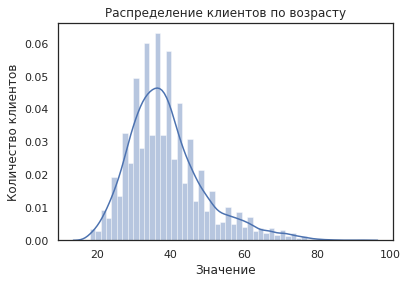

In [35]:
sns.distplot(df['Age'])
plt.title('Распределение клиентов по возрасту')
plt.ylabel('Количество клиентов')
plt.xlabel('Значение')
#    plt.legend(['Ок', 'Отток'])
plt.show()

In [36]:
print('Дисперсия первой выборки = ', round(np.var(df_churn0['Age']),2))
print('Дисперсия второй выборки = ', round(np.var(df_churn1['Age']),2))

Дисперсия первой выборки =  102.51
Дисперсия второй выборки =  95.24


Дисперсии выборок раздичаются несильно. Распределение доходов является непрерывным, но не походит на нормальное распределение из-за длинного хвоста.Поэтому вместо t-критерия Стьюдента будем использовать аналогичный методы U-критерий Манна — Уитни, которорый является непараметрическим аналогом критерия Стьюдента.

In [37]:
alpha = 0.05 # ваш код: задайте критический уровень статистической значимости

results = st.mannwhitneyu(
    df_churn0['Age'], 
    df_churn1['Age'])
# ваш код: проверьте гипотезу о равенстве меедиан двух независимых совокупностей

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.6052007159685838e-230
Отвергаем нулевую гипотезу


Проверим гипотезу о равенстве баллов скоринга между теми клиентами, которые ушли и теми, которые остались.

- Нулевая гипотеза: баллы скоринга у тех клиентов, которые ушли, и у тех, которые остались, равны
- Альтернативная гипотеза:баллы скоринга у тех клиентов, которые ушли, и у тех, которые остались, различны

Критический уровень статистической значимости зададим значение 0.05.

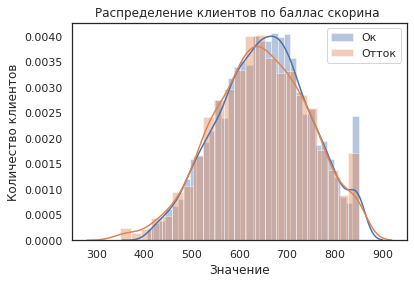

In [38]:
sns.distplot(df_churn0['score'])
sns.distplot(df_churn1['score'])
plt.title('Распределение клиентов по баллас скорина ')
plt.ylabel('Количество клиентов')
plt.xlabel('Значение')
plt.legend(['Ок', 'Отток'])
plt.show()

In [39]:
print('Дисперсия первой выборки = ', round(np.var(df_churn0['score']),2))
print('Дисперсия второй выборки = ', round(np.var(df_churn1['score']),2))

Дисперсия первой выборки =  9148.51
Дисперсия второй выборки =  10059.46


Дисперсии выборок раздичаются в пределах 10%. Распределение доходов является непрерывным, но не походит на нормальное распределение из-за выброса в районе 850 баллов. Поэтому вместо t-критерия Стьюдента будем использовать аналогичный методы U-критерий Манна — Уитни, которорый является непараметрическим аналогом критерия Стьюдента.

In [40]:
alpha = 0.05 # ваш код: задайте критический уровень статистической значимости

results = st.mannwhitneyu(
    df_churn0['score'], 
    df_churn1['score'])
# ваш код: проверьте гипотезу о равенстве медиан двух независимых совокупностей

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.00993433058636417
Отвергаем нулевую гипотезу


Были проверены гипотезы:
- 1) о равенстве дохода между теми клиентами, которые ушли и теми, которые остались. Гипотеза подтвердилась.
- 2) о равенстве возрастов между теми клиентами, которые ушли и теми, которые остались. Гипотеза не подтвердилась.
- 3) о равенстве баллов скоринга между теми клиентами, которые ушли и теми, которые остались. Гипотеза не подтвердилась.

Гипотезы были выбран на основании исследования доли оттока по признакам.

## Выводы

- В датасете 12 колонок и 10 тысяч строк. Пропуски отсутствуют во всех столбцах кроме "Баланса". Категориальные данные, такие как активность клиента и наличие кредитной карты уже преобразованы в систему 1/0. Пол клиента принимает значения М и Ж. Все типы данных имеют приемлемые для анализа значение. Дубликатов не обнаружено. Пропуски присутствуют только в балансе на карте, их около 36%. При первом взгляде на данные таблицы, пропуски в балансе не зависит от других данных. Минимальное значение баланса равно 3.7к, поэтому можно предположить, что пропуски-это нулевые значение. Но обычно на карте остаются небольшие суммы (копейки), даже если клиент ею не пользуется, и они должны значиться в балансе. Пропуски в данных не помешают дальнейшему анализу, поэтому оставляем их. При изучении зависимости оттока клиента от баланса на карте можно будет очистить датасет от пропусков.
- Баллы кредитного скоринга принимают значение от 350 до 850, в среднем 650 на клиента с разбросом около 100 баллов. Возраст клиентов варьируется от 18 до 92 лет, среднестатистическому клиенту 39 лет. В среднем в собственности клиентов 5 объектов. Баланс на карте варьируется от 4к до 251к рублей, среднее значение 120к рублей. Все клиенты используют от 1 до 4 продуктов банка, чаще всего 1-2-мя продуктами. Кредитная карта есть у 70% клиентов. Активных в плане банковской истории около 50% клиентов в выборке. Средняя зп клиента 100к. 20% клиентов в выборке перестали пользоваться услугами банка.
- В выборке примерно равное количество мужчин и женщин. Половина клиента пользуется услугами банка в Ярославле, остальные пополам распределены по двум другим городам. Очень малый процент клиентов пользуется 3-4-мя продуктами банка. У редких клиентов совсем нет имущества или же 10 объектов, остальные значения распределены равномерно. Распределение баллов скоринга походит на нормальное распределение со сдвигом вправо, но на уровне 850 баллов имеется выброс. Распределение возраста клиентов имеет длинный хвост в большую сторону, в основном возраст клиентов 30-50 лет. Зарплата клиентов распределена почти равномерно, скорее всего сотрудники банка вносят примерное ее значение. Баланс клиентов на счету имеет вид нормального распределения с довольно длинными хвостами в обе стороны.
- Согласно шкале Чеддока, связь между всеми признаками очень слабая. Больше всего между собой коррелируют возраст и отток. Чем старше клиент, тем больше вероятность, что он перестанет быть клиентом банка.Но и эта связь находится между уровнями "очень слабая" и "слабая".
- Исследование доли оттока по признаком показало, что: cредний скоринговый баланс примерно равен для ушедших и оставшихся клиентов, а вот клиенты с минимальными значениями баланса больше склонны уходить, та как у распределений отточников больший хвост в начале. Клиенты 40-45+ более склонны уходить, и такая тенденция наблюдается примерно до 65 лет. Количество объектов в собственности, судя по всему, не влияет на отток. На средних значениях баланса клиентов отток повышается. Отток для клиентов, использующих 3-4 продукта банка, выше, чем для 1-2 продуктов. Наличие кредитной карты слабо влияет на отток. Для активных/лояльных клиентов отток заметно ниже. Зарплата не значительно влияет на отток, но на значении примерно 180к имеется локальный пик распределения ушедших клиентов. Клиенты-мужчины заметно реже уходят из банка, нежели женщины. В процентном соотношении ниже всего отток клиентов в Ярославле, а выше всего в Ростове Великом.
- Для выделения портрета клиентов была использована кластеризация на основании алгоритма K-Means. На основе построения дендрограммы было выбрано 3 кластера. В каждом кластере от 1920 до 2454. Отток во втором кластере существенно выше, чем в третьем, 30% против 20%. По обученной модели можно сделать вывод, что к оттоку больше склонны клиенты-женщины, по другим признакам выводы сделать сложно.
- Гипотезы были выбран на основании исследования доли оттока по признакам. Были проверены гипотезы:
- 1) о равенстве дохода между теми клиентами, которые ушли и теми, которые остались. Гипотеза подтвердилась.
- 2) о равенстве возрастов между теми клиентами, которые ушли и теми, которые остались. Гипотеза не подтвердилась.
- 3) о равенстве баллов скоринга между теми клиентами, которые ушли и теми, которые остались. Гипотеза не подтвердилась.
- Дисперсии выборок во всех гипотезах различаются несильно. Распределение всех выборок непрерывное, но не походит на нормальное распределение. Поэтому вместо t-критерия Стьюдента использовался аналогичный метод U-критерий Манна — Уитни, которорый является непараметрическим аналогом критерия Стьюдента.

#### На данный момент средний отток равен 20 %. К оттоку склонны клиенты-женщины, клиенты с минимальными значениями скорингового баланса, клиенты 40-65 лет, клиенты с низкой активностью, клиенты из Ростова Великого.